In [1]:
# Fix randomness and hide warnings
seed = 164

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf

from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
from keras.applications.efficientnet_v2 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
import pandas as pd

2.13.0


In [2]:
data = np.load('/kaggle/input/challenge/dataset_refined.npz', allow_pickle=True)

images = data['arr_0']
labels = data['arr_1']
labels = np.array(labels)
images = np.array(images)

In [3]:
from imblearn.over_sampling import SMOTE


# Assuming you have a dataset with features 'images' and labels 'labels'

# Initialize the SMOTE object
smote = SMOTE(sampling_strategy=0.75, random_state=seed)

# Flatten the images
images_flat = images.reshape(images.shape[0], -1)  # Reshape to (num_samples, num_features)

# Now you can use SMOTE on 'images_flat'
images_smote, labels_smote = smote.fit_resample(images_flat, labels)


# Now, 'images_smote' and 'labels_smote' contain the oversampled dataset

#reshape the images

original_shape = (96, 96, 3)

images_original_shape = images_smote.reshape(-1, *original_shape)

In [4]:
#just for clarity
images_balanced = images_original_shape
labels_balanced = labels_smote

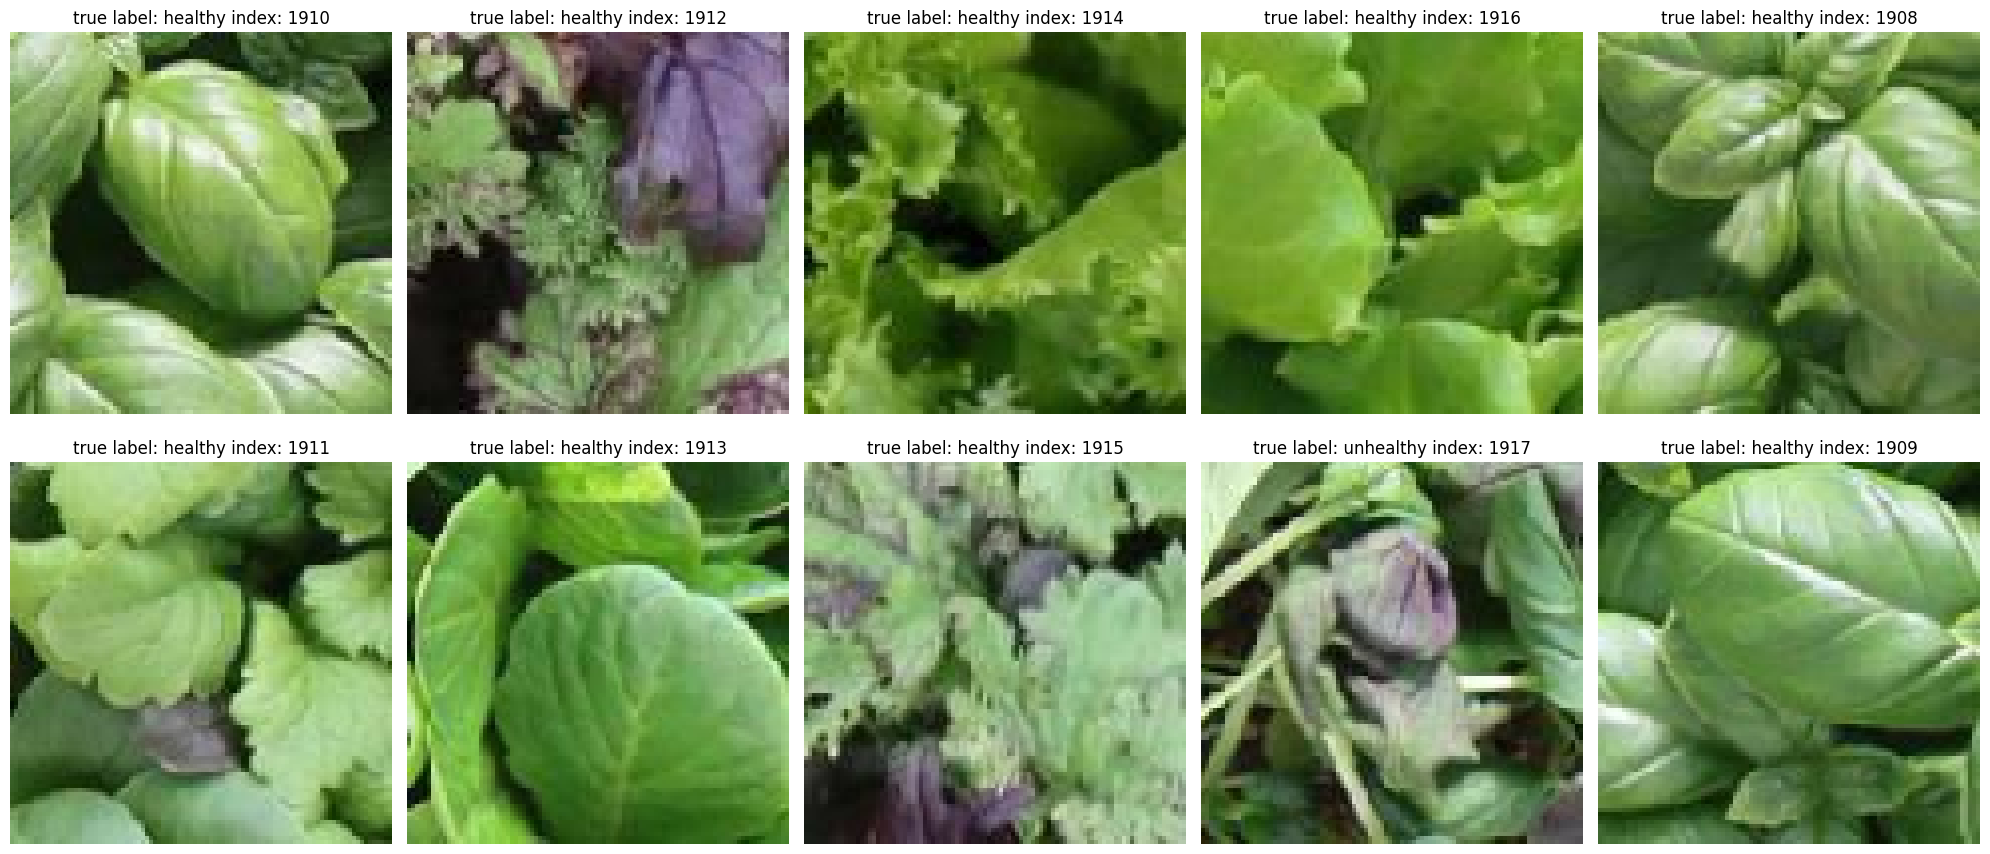

In [5]:
#SHow the data
# Number of images to display
size = labels_balanced.size
num_img = 10
# Create a random index to display every time a different set of images
random_index = np.random.rand()
random_index = int(random_index*(size-num_img))

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(random_index, random_index + num_img):
    title = 'true label: ' + str(labels_balanced[i]) + ' index: ' + str(i)
    ax = axes[i%2, i%num_img//2]
    ax.set_title(title)
    ax.imshow(np.clip(images_balanced[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
print('Dataset campionato: ' + str(labels_balanced.size))
print('Dataset originale: ' + str(labels.size))
counts, unique = np.unique(labels_balanced, return_counts = True)
for i in range(counts.size):
  print(counts[i] + ': ' + str(unique[i]))

Dataset campionato: 5355
Dataset originale: 4850
healthy: 3060
unhealthy: 2295


augmentation

In [7]:

# Assuming 'labels_balanced' is a NumPy array containing your categorical labels
labels_onehot = labels_balanced  # Replace with your actual labels

# Get the unique categories in your label array
unique_categories = np.unique(labels_onehot)

# Initialize an empty array for one-hot encoded labels
one_hot_labels = np.zeros((len(labels_onehot), len(unique_categories)))

# Create one-hot encoded labels
for i, category in enumerate(unique_categories):
    one_hot_labels[:, i] = (labels_onehot == category).astype(int)

# Now, 'one_hot_labels' contains the one-hot encoded labels

labels_balanced_onehot = one_hot_labels

In [8]:
# Define a function to perform MixUp on the dataset
def mixup_data(X, y, alpha=0.2):
    mixed_X = []
    mixed_y = []

    for i in range(len(X)):
        # Randomly select another sample to mix with
        j = np.random.randint(len(X))

        # Randomly select a mixing ratio from a beta distribution
        beta = np.random.beta(alpha, alpha)

        mixed_X.append((X[i] * beta) + (X[j] * (1 - beta)))
        mixed_y.append((y[i] * beta) + (y[j] * (1 - beta)))

    mixed_X = np.array(mixed_X)
    mixed_y = np.array(mixed_y)

    return mixed_X, mixed_y

# Perform MixUp on your training data
images_augmented, labels_augmented_onehot = mixup_data(images_balanced, labels_balanced_onehot, alpha=0.2)

In [9]:
#PREPARE FOR NEXT LAYER
labels_augmented = labels_augmented_onehot
images_augmented = images_augmented

In [10]:
def cutmix(images, labels, beta=1.0):
    """
    Apply CutMix data augmentation to a dataset.

    Args:
    images (numpy.ndarray): An array of images with shape (num_samples, height, width, channels).
    labels (numpy.ndarray): An array of labels with shape (num_samples, num_classes).
    beta (float): CutMix hyperparameter (default is 1.0).

    Returns:
    mixed_images (numpy.ndarray): Mixed images.
    mixed_labels (numpy.ndarray): Mixed labels.
    """
    num_samples, height, width, channels = images.shape

    # Randomly choose another sample to cut and mix with
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    mixed_images = images.copy()
    mixed_labels = labels.copy()

    for i in range(num_samples):
        j = indices[i]
        lam = np.random.beta(beta, beta)
        x, y, h, w = get_random_bbox(width, height, lam)
        mixed_images[i, y:y+h, x:x+w, :] = images[j, y:y+h, x:x+w, :]
        lam = 1 - (w * h / (width * height))
        mixed_labels[i] = lam * labels[i] + (1 - lam) * labels[j]

    return mixed_images, mixed_labels

def get_random_bbox(width, height, lam):
    r_x = np.random.randint(width)
    r_y = np.random.randint(height)
    r_w = int(width * np.sqrt(1 - lam))
    r_h = int(height * np.sqrt(1 - lam))
    x1 = np.clip(r_x - r_w // 2, 0, width)
    y1 = np.clip(r_y - r_h // 2, 0, height)
    x2 = np.clip(r_x + r_w // 2, 0, width)
    y2 = np.clip(r_y + r_h // 2, 0, height)
    return x1, y1, x2 - x1, y2 - y1

# Example usage:
# Assuming 'images' is your image dataset and 'labels' are the corresponding labels
images_augmented_tot, labels_augmented_onehot_tot = cutmix(images_augmented, labels_augmented, beta=1.0)

In [11]:
#PREPARE FOR NEXT LAYER
labels_augmented = labels_augmented_onehot_tot
images_augmented = images_augmented_tot

In [12]:
from sklearn.utils import shuffle
# Concatenate the original dataset with the mixup dataset
augmented_images_conc = np.concatenate((images_balanced, images_augmented), axis=0)
augmented_labels_conc = np.concatenate((labels_balanced_onehot, labels_augmented), axis=0)

# Shuffle the concatenated dataset
augmented_images_conc, augmented_labels_conc = shuffle(augmented_images_conc, augmented_labels_conc, random_state=seed)

#to make sure the next blocks work
images_augmented = augmented_images_conc
labels_augmented = augmented_labels_conc

In [13]:
if labels_augmented.ndim == 1:
  print("eseguendo onehot\n")

  # Assuming 'labels_balanced' is a NumPy array containing your categorical labels
  labels_onehot = labels_augmented  # Replace with your actual labels

  # Get the unique categories in your label array
  unique_categories = np.unique(labels_onehot)

  # Initialize an empty array for one-hot encoded labels
  one_hot_labels = np.zeros((len(labels_onehot), len(unique_categories)))

  # Create one-hot encoded labels
  for i, category in enumerate(unique_categories):
     one_hot_labels[:, i] = (labels_onehot == category).astype(int)

  # Now, 'one_hot_labels' contains the one-hot encoded labels

  labels_augmented_onehot = one_hot_labels


else:
  print("one-hot già eseguito\n")

  labels_augmented_onehot = labels_augmented

one-hot già eseguito



In [14]:
#remember to call the results of the previous section X (processed dataset) and y (one hot encoded labels)
X = images_augmented
y = labels_augmented
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.15, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=.10, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8192, 96, 96, 3), y_train shape: (8192, 2)
X_val shape: (911, 96, 96, 3), y_val shape: (911, 2)
X_test shape: (1607, 96, 96, 3), y_test shape: (1607, 2)


Efficient net transfer learning

In [16]:
#EfficientNetV2S
efficientnet = tfk.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    classes=2,
    classifier_activation="softmax",
)

214201816/214201816 [==============================] - 1s 0us/step


In [17]:
from tensorflow.keras.regularizers import l2

def build_efficientnet():

# Use the supernet as feature extractor, i.e. freeze all its weigths
    efficientnet.trainable = False

# Create an input layer with shape (96, 96, 3)
    inputs = tfk.Input(shape=(96, 96, 3))

# Connect MobileNetV2 to the input
    x = efficientnet(inputs)

#Hyperparameters obtained using the tuner library
# Dense layer with regularizer between mobile net and batch
  #x = tfkl.Dense(units=hp.Int("units", min_value=32, max_value=512, step=32),
                 #kernel_regularizer=l2(0.01))(x)
    x = tfkl.Dense(1280, activation='relu')(x)
#x = tfkl.Dense(1280, activation='relu')(x)

# Add Batch Normalization
    x = tfkl.BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x)
    x = tfkl.Dropout(0.5)(x)

# Dense layer between batch and dropout with regularizer
    x = tfkl.Dense(640, activation='relu')(x)
#x = tfkl.Dense(640, activation='relu')(x)

# Add a Dropout layer with 0.4
    x = tfkl.BatchNormalization(epsilon=1e-06, momentum=0.9, weights=None)(x)
    x = tfkl.Dropout(0.5)(x)

# Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
    tl2_model = tfk.Model(inputs=inputs, outputs=outputs, name='model_efficientnet')


    return tl2_model


In [18]:
tl2_model = build_efficientnet()
# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl2_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

In [19]:
# Train the model
# Batch size = 30, dropout layer = 0.4, inputs are denormalized since we need to apply the preprocessing thought for MobileNet
history = tl2_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    #sample_weight = weights,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)]
).history

Epoch 1/200
512/512 [==============================] - 50s 43ms/step - loss: 0.8398 - accuracy: 0.6396 - val_loss: 0.5265 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 2/200
512/512 [==============================] - 15s 30ms/step - loss: 0.6170 - accuracy: 0.6876 - val_loss: 0.5187 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 3/200
512/512 [==============================] - 15s 29ms/step - loss: 0.5877 - accuracy: 0.7052 - val_loss: 0.5169 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 4/200
512/512 [==============================] - 15s 30ms/step - loss: 0.5837 - accuracy: 0.7158 - val_loss: 0.5056 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 5/200
512/512 [==============================] - 15s 30ms/step - loss: 0.5819 - accuracy: 0.7114 - val_loss: 0.5037 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 6/200
512/512 [==============================] - 16s 30ms/step - loss: 0.5701 - accuracy: 0.7260 - val_loss: 0.4967 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 7/200
512/512 [==============================]

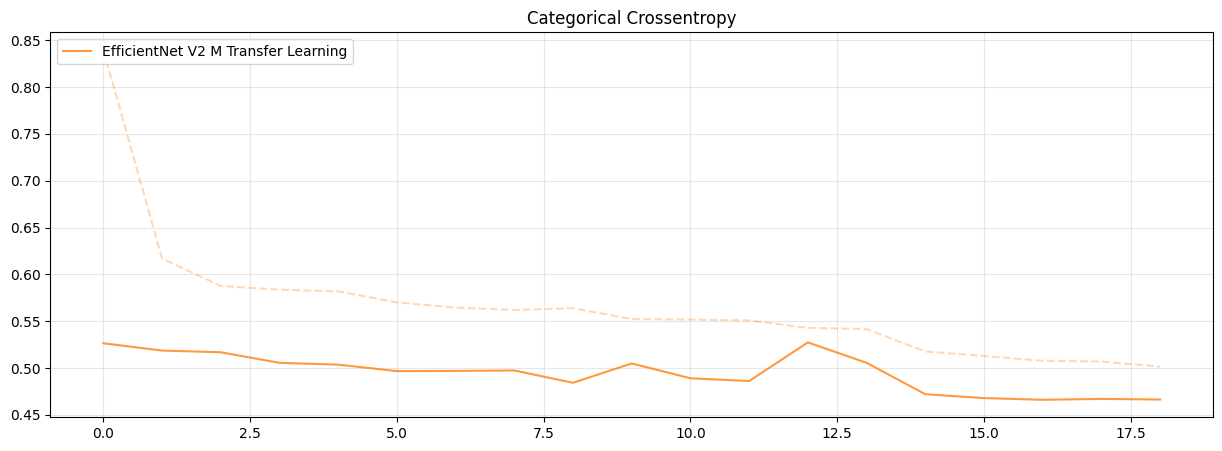

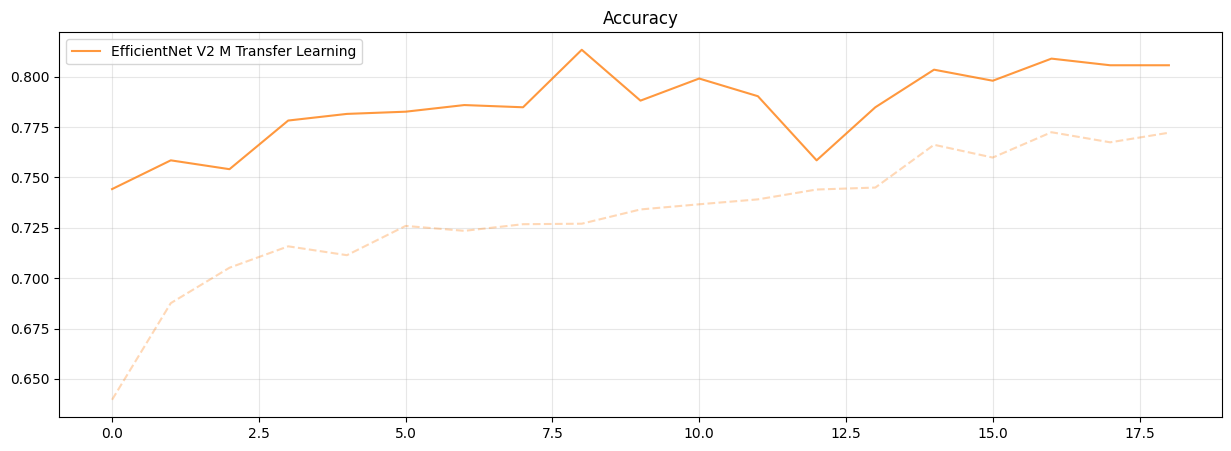

In [20]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='EfficientNet V2 M Transfer Learning', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='EfficientNet V2 M Transfer Learning', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [21]:
tl2_model.save('/kaggle/working/TransferLearningModelEfficientNetS')

Predictions Shape: (1607, 2)
Accuracy: 0.7629
Precision: 0.7584
Recall: 0.7594
F1: 0.7589


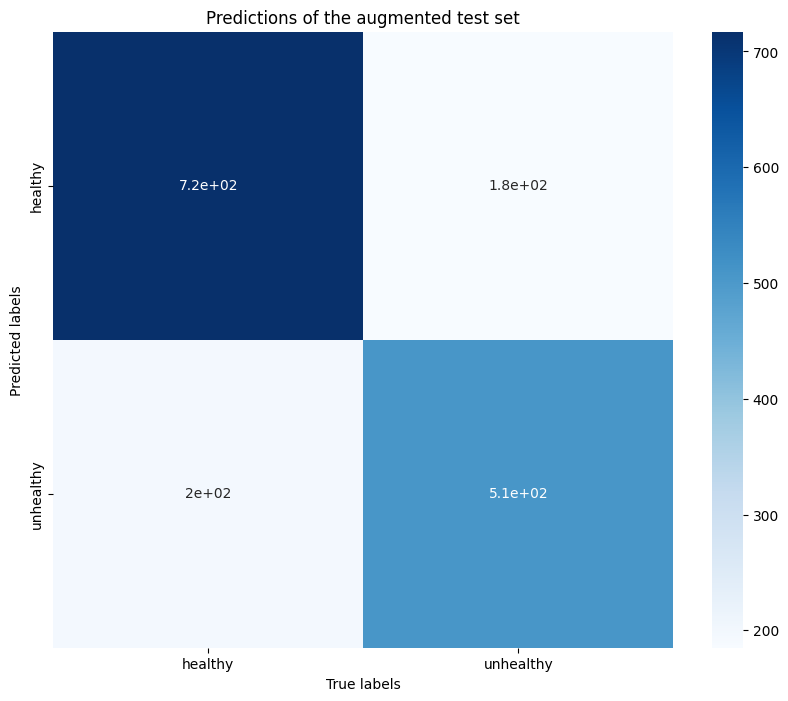

In [22]:
# Predict labels for the entire test set (augmented)
X_test = preprocess_input(X_test*255)
predictions = tl2_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.title('Predictions of the augmented test set')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [23]:
# Re-load the model after transfer learning
ft2_model = tf.keras.models.load_model('/kaggle/working/TransferLearningModelEfficientNetS')
del tl2_model

#ft2_model = build_efficientnet()
ft2_model.summary()

# Set all MobileNetV2 layers as trainable
ft2_model.get_layer('efficientnetv2-m').trainable = True


Model: "model_efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
                                                                 
 dense (Dense)               (None, 1280)              1639680   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 640)        

In [24]:
# Freeze first N layers, e.g., until the 133rd one
#meno layer??
#N = 71
N = 380
for i, layer in enumerate(ft2_model.get_layer('efficientnetv2-m').layers[:N]):
  layer.trainable=False
ft2_model.summary()

ft2_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

Model: "model_efficientnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Function  (None, 1280)              53150388  
 al)                                                             
                                                                 
 dense (Dense)               (None, 1280)              1639680   
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 640)        

In [25]:
# Fine-tune the model
history = ft2_model.fit(
    x = preprocess_input(X_train*255), 
    y = y_train,
    #sample_weight = weights,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), 
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)]
).history

Epoch 1/200
512/512 [==============================] - 121s 86ms/step - loss: 0.6230 - accuracy: 0.6890 - val_loss: 0.4912 - val_accuracy: 0.7914 - lr: 1.0000e-05
Epoch 2/200
512/512 [==============================] - 38s 75ms/step - loss: 0.5309 - accuracy: 0.7494 - val_loss: 0.4595 - val_accuracy: 0.8123 - lr: 1.0000e-05
Epoch 3/200
512/512 [==============================] - 38s 75ms/step - loss: 0.4795 - accuracy: 0.7892 - val_loss: 0.4284 - val_accuracy: 0.8419 - lr: 1.0000e-05
Epoch 4/200
512/512 [==============================] - 39s 75ms/step - loss: 0.4580 - accuracy: 0.8080 - val_loss: 0.4163 - val_accuracy: 0.8584 - lr: 1.0000e-05
Epoch 5/200
512/512 [==============================] - 38s 75ms/step - loss: 0.4307 - accuracy: 0.8243 - val_loss: 0.4031 - val_accuracy: 0.8551 - lr: 1.0000e-05
Epoch 6/200
512/512 [==============================] - 39s 75ms/step - loss: 0.4003 - accuracy: 0.8473 - val_loss: 0.3933 - val_accuracy: 0.8595 - lr: 1.0000e-05
Epoch 7/200
512/512 [======

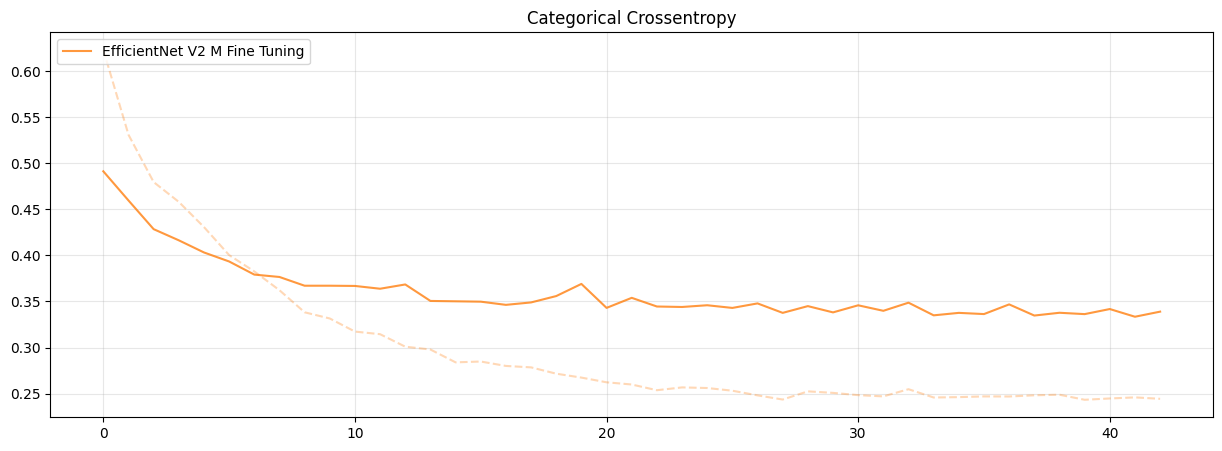

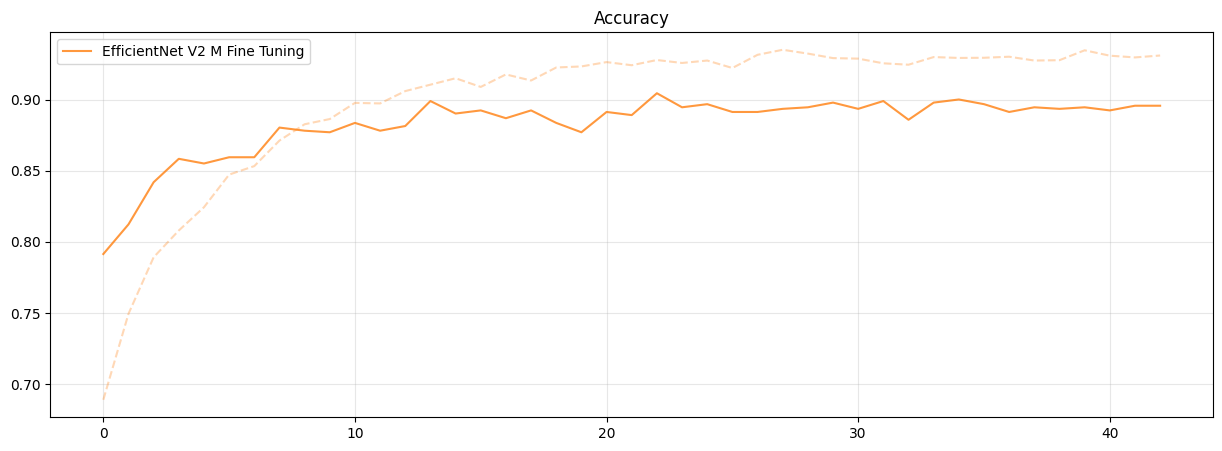

In [26]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='EfficientNet V2 M Fine Tuning', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='EfficientNet V2 M Fine Tuning', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [27]:
# Save the best model
ft2_model.save('/kaggle/working/FineTuningModelEfficientNetM')

Predictions Shape: (1607, 2)
Accuracy: 0.5277
Precision: 0.4979
Recall: 0.4983
F1: 0.4863


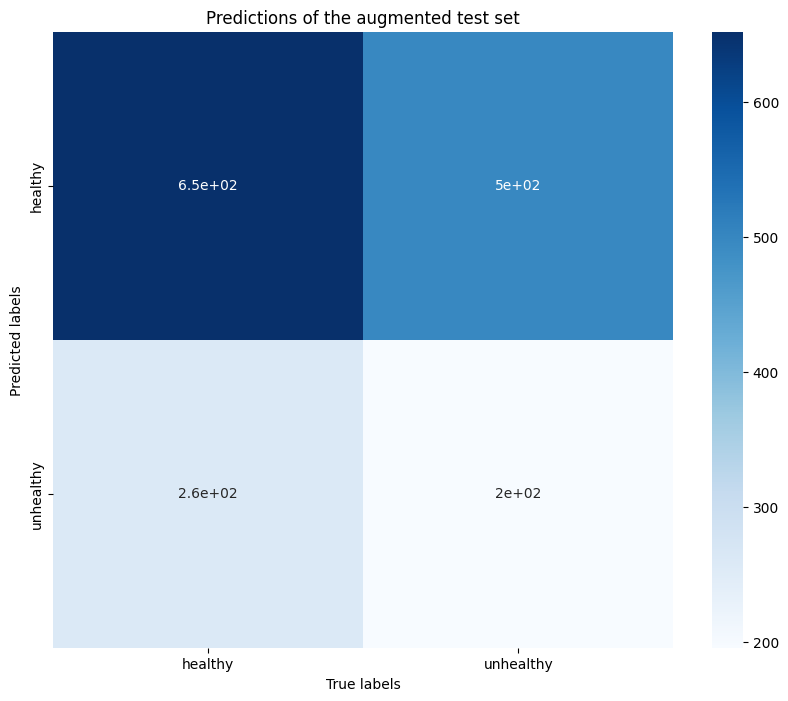

In [28]:
# Predict labels for the entire test set (augmented)
X_test = preprocess_input(X_test*255)
predictions = ft2_model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.title('Predictions of the augmented test set')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()